# Image Classification

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt

torch.manual_seed(42) # We are setting a PyTorch random seed for reproducibility.

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Architecture

In [16]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

class CutOut(object):
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes  # Number of holes to cut out from the image
        self.length = length   # Length of each square hole

    def __call__(self, img):
        h = img.size(1) # Get the height of the image
        w = img.size(2) # Get the width of the image
        mask = torch.ones((h, w), dtype=torch.float32) # Create a mask of ones (same height & width as the image)
        
        for _ in range(self.n_holes):
            # Randomly select a center point (x, y) for the hole
            y = torch.randint(0, h, (1,)).item()
            x = torch.randint(0, w, (1,)).item()
             # Compute the coordinates of the square hole
            y1 = max(0, y - self.length // 2)
            y2 = min(h, y + self.length // 2)
            x1 = max(0, x - self.length // 2)
            x2 = min(w, x + self.length // 2)
            mask[y1:y2, x1:x2] = 0. # Set the region of the mask to zero (this will cut out that region)
        mask = mask.expand_as(img)  # Expand the 2D mask to match all image channels (C x H x W)
        img = img * mask # Apply the mask to the image (zeroing out masked regions)
        
        return img

# Data loading with augmentation
def load_data_cifar10(batch_size, resize=None):
    trans_list = [
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), # Crop the given image at a random location
        transforms.RandomHorizontalFlip(),  # Horizontally flip the given image randomly
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5),
        CutOut(n_holes=1, length=8),  # Randomly remove a square region of the image
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
    trans = transforms.Compose(trans_list)
    # No data augmentation during testing
    test_trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    cifar_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    cifar_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=test_trans, download=True)
    
    return (torch.utils.data.DataLoader(cifar_train, batch_size, shuffle=True, num_workers=0),
            torch.utils.data.DataLoader(cifar_test, batch_size, shuffle=False, num_workers=0))

# Model architecture - Same as the basic architecture
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels_list, kernel_sizes, strides=1, paddings=0):
        super(IntermediateBlock, self).__init__()
        
        if isinstance(strides, int):
            strides = [strides] * len(out_channels_list)
        if isinstance(paddings, int):
            paddings = [paddings] * len(out_channels_list)
            
        self.conv_layers = nn.ModuleList()
        for out_channels, kernel_size, stride, padding in zip(out_channels_list, kernel_sizes, strides, paddings):
            self.conv_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
            )
            
        self.fc = nn.Linear(in_channels, len(out_channels_list))
        
    def forward(self, x):
        m = torch.mean(x, dim=[2, 3])
        a = self.fc(m)
        a = F.softmax(a, dim=1)
        
        outputs = []
        for i, conv in enumerate(self.conv_layers):
            conv_out = conv(x)
            weight = a[:, i].view(-1, 1, 1, 1)
            weighted_out = weight * conv_out
            outputs.append(weighted_out)
            
        x_out = torch.sum(torch.stack(outputs), dim=0)
        return x_out

class OutputBlock(nn.Module):
    def __init__(self, in_channels, hidden_sizes=[], num_classes=10, dropout_rate=0.3):
        super(OutputBlock, self).__init__()
        
        layers = []
        prev_size = in_channels
        
        for size in hidden_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))  # Use dropout in the output layer for training
            prev_size = size
            
        layers.append(nn.Linear(prev_size, num_classes))
        self.fc_layers = nn.Sequential(*layers)
        
    def forward(self, x):
        m = torch.mean(x, dim=[2, 3])
        logits = self.fc_layers(m)
        return logits

class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()

        # Increased the number of layers and blocks as compared to the basic structure
        
        self.block1 = IntermediateBlock(
            in_channels=3,    # RGB colour channels will be the input
            out_channels_list=[64, 64, 64, 64],  # 4 layers with 64 output channels in each
            kernel_sizes=[3, 5, 7, 1],  # 4 different kernel sizes
            paddings=[1, 2, 3, 0]  # Padding for all 4 layers
        )
        
        self.block2 = IntermediateBlock(
            in_channels=64,
            out_channels_list=[128, 128, 128],
            kernel_sizes=[3, 5, 1],
            paddings=[1, 2, 0]
        )

        self.block3 = IntermediateBlock(
            in_channels=128,
            out_channels_list=[256, 256],
            kernel_sizes=[3, 1],
            paddings=[1, 0]
        )

        self.block4 = IntermediateBlock(
            in_channels=256,
            out_channels_list=[512, 512],
            kernel_sizes=[3, 1],
            paddings=[1, 0]
        )

        self.pool_max = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.pool_avg = nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool_avg = nn.AdaptiveAvgPool2d((2,2))
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.2)
        
        self.output = OutputBlock(
            in_channels=512,
            hidden_sizes=[1024, 512],
            num_classes=10,
            dropout_rate=0.5
        )

    def forward(self, x):
        # Block 1
        x = self.block1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool_max(x)
    
        # Block 2
        x = self.block2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool_max(x)

        # Block 3
        x = self.block3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool_max(x)
    
        # Block 4
        x = self.block4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool_avg(x)
    
        x = self.output(x)
        return x

# Initialise weights using Xavier initialisation
def init_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):  # Handle BatchNorm
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
        
def evaluate_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            total_loss += criterion(outputs, y).item()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    return total_loss / len(data_loader), 100 * correct / total

# Implement Early stopping in order to save computation time and effort
class EarlyStopping:
    def __init__(self, patience=10, delta=0.001, save_path="best_model.pth"):
        self.patience = patience
        self.delta = delta  # Minimum improvement threshold
        self.best_acc = 0.0
        self.counter = 0
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, test_acc, model):
        if test_acc > self.best_acc + self.delta:  # Check if the test accuracy has improved by delta
            self.best_acc = test_acc
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Main training function
def train_model():
    # Initialize
    batch_size = 128
    train_iter, test_iter = load_data_cifar10(batch_size)

    model = CIFAR10Model().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Cross-entropy loss with label smoothing
    model.apply(init_weights_xavier)  # Weight initialization
    optimizer = Adam(model.parameters(), lr=0.005, weight_decay=1e-5)  # Adam optimizer
    steps_per_epoch = len(train_iter)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.005,                 # Peak LR
        steps_per_epoch=steps_per_epoch,
        epochs=100,
        pct_start=0.3,                # 30% of epochs increasing LR
        anneal_strategy='cos',       # Cosine decay
        div_factor=25.0,             # Initial LR = max_lr / div_factor
        final_div_factor=1e4,        # Final LR = initial / final_div_factor
    )
    early_stopping = EarlyStopping(patience=20, delta=0.01)  # Define early stopping

    metrics = {'batch_losses': [], 'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []} # Metrics to be saved

    for epoch in range(100):
        model.train()
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        for X, y in tqdm(train_iter, desc=f"Train Epoch {epoch+1}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()  # Zero out gradients from the previous step

            outputs = model(X)  # Forward pass: compute model predictions
            loss = criterion(outputs, y)  # Compute the loss between predictions and actual labels
            loss.backward()  # Backward pass: compute gradients
            optimizer.step()  # Update model weights
            scheduler.step()  # Update learning rate using the scheduler
            metrics['batch_losses'].append(loss.item())  # Store the loss value for this batch (for plotting later)
            epoch_train_loss += loss.item()  # Accumulate total training loss for the epoch
        #     _, predicted = torch.max(outputs, 1)
        #     total += y.size(0)
        #     correct += (predicted == y).sum().item()  # Compute number of correct predictions in the batch

        # avg_train_loss = epoch_train_loss / len(train_iter) # Compute average training loss for the epoch
        # train_acc = 100 * correct / total # Compute training accuracy for the epoch

        train_loss, train_acc = evaluate_model(model, train_iter, device, criterion) # Get the training loss and accuracy
        test_loss, test_acc = evaluate_model(model, test_iter, device, criterion) # Evaluate the model on the test dataset

        # Log metrics
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['test_loss'].append(test_loss)
        metrics['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

        # Apply early stopping if test accuracy hasn't improved
        early_stopping(test_acc, model)  # Instead of test_loss
        if early_stopping.early_stop:
            print(f"Early stopping triggered! Best acc: {early_stopping.best_acc:.2f}%")
            break

        # scheduler.step()

    print(f"Training complete. Best Test Acc: {max(metrics['test_acc']):.2f}%")

    return model, metrics

In [17]:
def plot_metrics(metrics):
    # Plot batch-wise training loss
    plt.figure(figsize=(10, 4))
    plt.plot(metrics['batch_losses'], label='Training Loss (per batch)')
    plt.title('Training Loss Per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot train/test accuracy per epoch
    plt.figure(figsize=(10, 4))
    plt.plot(metrics['train_acc'], label='Training Accuracy')
    plt.plot(metrics['test_acc'], label='Testing Accuracy')
    plt.title('Training vs Testing Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Evaluation

In [18]:
model, metrics = train_model()

Files already downloaded and verified
Files already downloaded and verified


Train Epoch 1: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


Epoch 1: Train Loss: 1.7123 | Train Acc: 39.51% | Test Loss: 1.6080 | Test Acc: 43.67%


Train Epoch 2: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s]


Epoch 2: Train Loss: 1.6659 | Train Acc: 44.15% | Test Loss: 1.4604 | Test Acc: 51.83%


Train Epoch 3: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 3: Train Loss: 1.4924 | Train Acc: 49.83% | Test Loss: 1.3869 | Test Acc: 54.15%


Train Epoch 4: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


Epoch 4: Train Loss: 1.4916 | Train Acc: 51.51% | Test Loss: 1.4032 | Test Acc: 55.19%


Train Epoch 5: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 5: Train Loss: 1.3508 | Train Acc: 56.55% | Test Loss: 1.2257 | Test Acc: 62.60%


Train Epoch 6: 100%|██████████| 391/391 [00:32<00:00, 12.05it/s]


Epoch 6: Train Loss: 1.3599 | Train Acc: 56.76% | Test Loss: 1.2441 | Test Acc: 61.69%


Train Epoch 7: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 7: Train Loss: 1.3562 | Train Acc: 56.46% | Test Loss: 1.2342 | Test Acc: 62.21%


Train Epoch 8: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


Epoch 8: Train Loss: 1.3252 | Train Acc: 58.25% | Test Loss: 1.1560 | Test Acc: 64.92%


Train Epoch 9: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]


Epoch 9: Train Loss: 1.1909 | Train Acc: 63.91% | Test Loss: 1.0784 | Test Acc: 68.02%


Train Epoch 10: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 10: Train Loss: 1.2571 | Train Acc: 59.77% | Test Loss: 1.1307 | Test Acc: 65.51%


Train Epoch 11: 100%|██████████| 391/391 [00:32<00:00, 12.04it/s]


Epoch 11: Train Loss: 1.1564 | Train Acc: 64.75% | Test Loss: 1.0152 | Test Acc: 70.61%


Train Epoch 12: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 12: Train Loss: 1.2035 | Train Acc: 63.74% | Test Loss: 1.0883 | Test Acc: 69.08%


Train Epoch 13: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 13: Train Loss: 1.1103 | Train Acc: 66.85% | Test Loss: 0.9765 | Test Acc: 72.92%


Train Epoch 14: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s]


Epoch 14: Train Loss: 1.0784 | Train Acc: 69.15% | Test Loss: 0.9372 | Test Acc: 74.61%


Train Epoch 15: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]


Epoch 15: Train Loss: 1.0375 | Train Acc: 69.33% | Test Loss: 0.9294 | Test Acc: 74.53%


Train Epoch 16: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 16: Train Loss: 1.0535 | Train Acc: 69.46% | Test Loss: 0.9630 | Test Acc: 73.94%


Train Epoch 17: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 17: Train Loss: 1.0102 | Train Acc: 71.21% | Test Loss: 0.8949 | Test Acc: 76.52%


Train Epoch 18: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]


Epoch 18: Train Loss: 1.0213 | Train Acc: 70.58% | Test Loss: 0.9408 | Test Acc: 74.05%


Train Epoch 19: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]


Epoch 19: Train Loss: 1.0287 | Train Acc: 69.79% | Test Loss: 0.9028 | Test Acc: 75.42%


Train Epoch 20: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 20: Train Loss: 0.9289 | Train Acc: 74.47% | Test Loss: 0.8077 | Test Acc: 79.33%


Train Epoch 21: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]


Epoch 21: Train Loss: 0.9346 | Train Acc: 74.53% | Test Loss: 0.8080 | Test Acc: 79.53%


Train Epoch 22: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


Epoch 22: Train Loss: 0.9662 | Train Acc: 73.13% | Test Loss: 0.8604 | Test Acc: 77.54%


Train Epoch 23: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]


Epoch 23: Train Loss: 0.9230 | Train Acc: 75.06% | Test Loss: 0.8247 | Test Acc: 79.51%


Train Epoch 24: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


Epoch 24: Train Loss: 0.9288 | Train Acc: 74.64% | Test Loss: 0.8309 | Test Acc: 79.13%


Train Epoch 25: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


Epoch 25: Train Loss: 0.9008 | Train Acc: 75.48% | Test Loss: 0.7966 | Test Acc: 80.26%


Train Epoch 26: 100%|██████████| 391/391 [00:32<00:00, 12.04it/s]


Epoch 26: Train Loss: 0.8641 | Train Acc: 77.26% | Test Loss: 0.7542 | Test Acc: 82.40%


Train Epoch 27: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


Epoch 27: Train Loss: 0.9314 | Train Acc: 74.62% | Test Loss: 0.8312 | Test Acc: 79.07%


Train Epoch 28: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


Epoch 28: Train Loss: 0.9151 | Train Acc: 75.40% | Test Loss: 0.7848 | Test Acc: 81.30%


Train Epoch 29: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


Epoch 29: Train Loss: 0.8693 | Train Acc: 77.25% | Test Loss: 0.7580 | Test Acc: 81.89%


Train Epoch 30: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 30: Train Loss: 0.8641 | Train Acc: 77.19% | Test Loss: 0.7506 | Test Acc: 82.27%


Train Epoch 31: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch 31: Train Loss: 0.8301 | Train Acc: 78.78% | Test Loss: 0.7510 | Test Acc: 82.10%


Train Epoch 32: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]


Epoch 32: Train Loss: 0.8617 | Train Acc: 77.79% | Test Loss: 0.7565 | Test Acc: 82.22%


Train Epoch 33: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]


Epoch 33: Train Loss: 0.8592 | Train Acc: 78.09% | Test Loss: 0.7596 | Test Acc: 82.28%


Train Epoch 34: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


Epoch 34: Train Loss: 0.8415 | Train Acc: 78.93% | Test Loss: 0.7501 | Test Acc: 82.65%


Train Epoch 35: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


Epoch 35: Train Loss: 0.8196 | Train Acc: 79.35% | Test Loss: 0.7359 | Test Acc: 82.49%


Train Epoch 36: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 36: Train Loss: 0.7855 | Train Acc: 80.33% | Test Loss: 0.7169 | Test Acc: 83.68%


Train Epoch 37: 100%|██████████| 391/391 [00:32<00:00, 12.04it/s]


Epoch 37: Train Loss: 0.8124 | Train Acc: 79.58% | Test Loss: 0.7220 | Test Acc: 83.21%


Train Epoch 38: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 38: Train Loss: 0.7804 | Train Acc: 80.80% | Test Loss: 0.7036 | Test Acc: 84.11%


Train Epoch 39: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 39: Train Loss: 0.8155 | Train Acc: 79.69% | Test Loss: 0.7266 | Test Acc: 83.41%


Train Epoch 40: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]


Epoch 40: Train Loss: 0.8160 | Train Acc: 79.41% | Test Loss: 0.7242 | Test Acc: 83.15%


Train Epoch 41: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 41: Train Loss: 0.7831 | Train Acc: 80.61% | Test Loss: 0.6925 | Test Acc: 84.37%


Train Epoch 42: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 42: Train Loss: 0.7854 | Train Acc: 80.65% | Test Loss: 0.7236 | Test Acc: 83.21%


Train Epoch 43: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]


Epoch 43: Train Loss: 0.7630 | Train Acc: 81.54% | Test Loss: 0.6945 | Test Acc: 84.51%


Train Epoch 44: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 44: Train Loss: 0.8068 | Train Acc: 80.01% | Test Loss: 0.6978 | Test Acc: 84.45%


Train Epoch 45: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


Epoch 45: Train Loss: 0.7176 | Train Acc: 83.28% | Test Loss: 0.6753 | Test Acc: 85.14%


Train Epoch 46: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 46: Train Loss: 0.7206 | Train Acc: 83.21% | Test Loss: 0.6462 | Test Acc: 86.24%


Train Epoch 47: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


Epoch 47: Train Loss: 0.7174 | Train Acc: 83.14% | Test Loss: 0.6510 | Test Acc: 85.80%


Train Epoch 48: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


Epoch 48: Train Loss: 0.7313 | Train Acc: 82.87% | Test Loss: 0.6683 | Test Acc: 85.39%


Train Epoch 49: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


Epoch 49: Train Loss: 0.7180 | Train Acc: 83.43% | Test Loss: 0.6540 | Test Acc: 86.00%


Train Epoch 50: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 50: Train Loss: 0.6874 | Train Acc: 84.03% | Test Loss: 0.6450 | Test Acc: 85.97%


Train Epoch 51: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


Epoch 51: Train Loss: 0.7168 | Train Acc: 82.94% | Test Loss: 0.6599 | Test Acc: 85.80%


Train Epoch 52: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 52: Train Loss: 0.6740 | Train Acc: 85.02% | Test Loss: 0.6277 | Test Acc: 86.88%


Train Epoch 53: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]


Epoch 53: Train Loss: 0.6944 | Train Acc: 83.94% | Test Loss: 0.6522 | Test Acc: 85.63%


Train Epoch 54: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 54: Train Loss: 0.7210 | Train Acc: 83.26% | Test Loss: 0.6626 | Test Acc: 85.41%


Train Epoch 55: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 55: Train Loss: 0.6587 | Train Acc: 85.53% | Test Loss: 0.6231 | Test Acc: 87.00%


Train Epoch 56: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]


Epoch 56: Train Loss: 0.6713 | Train Acc: 84.85% | Test Loss: 0.6272 | Test Acc: 86.73%


Train Epoch 57: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


Epoch 57: Train Loss: 0.6644 | Train Acc: 85.38% | Test Loss: 0.6381 | Test Acc: 87.09%


Train Epoch 58: 100%|██████████| 391/391 [00:31<00:00, 12.25it/s]


Epoch 58: Train Loss: 0.6602 | Train Acc: 85.20% | Test Loss: 0.6132 | Test Acc: 87.77%


Train Epoch 59: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Epoch 59: Train Loss: 0.6360 | Train Acc: 86.25% | Test Loss: 0.6140 | Test Acc: 87.49%


Train Epoch 60: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]


Epoch 60: Train Loss: 0.6380 | Train Acc: 86.42% | Test Loss: 0.6185 | Test Acc: 87.01%


Train Epoch 61: 100%|██████████| 391/391 [00:32<00:00, 12.00it/s]


Epoch 61: Train Loss: 0.6279 | Train Acc: 86.61% | Test Loss: 0.6072 | Test Acc: 87.84%


Train Epoch 62: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]


Epoch 62: Train Loss: 0.6294 | Train Acc: 86.68% | Test Loss: 0.6165 | Test Acc: 87.10%


Train Epoch 63: 100%|██████████| 391/391 [00:32<00:00, 12.06it/s]


Epoch 63: Train Loss: 0.5915 | Train Acc: 88.12% | Test Loss: 0.5872 | Test Acc: 88.39%


Train Epoch 64: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 64: Train Loss: 0.6034 | Train Acc: 87.69% | Test Loss: 0.5948 | Test Acc: 88.72%


Train Epoch 65: 100%|██████████| 391/391 [00:32<00:00, 12.04it/s]


Epoch 65: Train Loss: 0.5992 | Train Acc: 87.76% | Test Loss: 0.5945 | Test Acc: 88.29%


Train Epoch 66: 100%|██████████| 391/391 [00:32<00:00, 12.02it/s]


Epoch 66: Train Loss: 0.5725 | Train Acc: 88.57% | Test Loss: 0.5749 | Test Acc: 88.94%


Train Epoch 67: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]


Epoch 67: Train Loss: 0.5877 | Train Acc: 88.11% | Test Loss: 0.5869 | Test Acc: 88.29%


Train Epoch 68: 100%|██████████| 391/391 [00:32<00:00, 12.03it/s]


Epoch 68: Train Loss: 0.5764 | Train Acc: 88.55% | Test Loss: 0.5728 | Test Acc: 88.97%


Train Epoch 69: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s]


Epoch 69: Train Loss: 0.5718 | Train Acc: 88.74% | Test Loss: 0.5689 | Test Acc: 89.30%


Train Epoch 70: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


Epoch 70: Train Loss: 0.5555 | Train Acc: 89.38% | Test Loss: 0.5668 | Test Acc: 89.45%


Train Epoch 71: 100%|██████████| 391/391 [00:37<00:00, 10.35it/s]


Epoch 71: Train Loss: 0.5478 | Train Acc: 89.72% | Test Loss: 0.5645 | Test Acc: 89.49%


Train Epoch 72: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]


Epoch 72: Train Loss: 0.5498 | Train Acc: 89.73% | Test Loss: 0.5667 | Test Acc: 89.66%


Train Epoch 73: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 73: Train Loss: 0.5270 | Train Acc: 90.54% | Test Loss: 0.5535 | Test Acc: 89.84%


Train Epoch 74: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]


Epoch 74: Train Loss: 0.5249 | Train Acc: 90.50% | Test Loss: 0.5487 | Test Acc: 90.05%


Train Epoch 75: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]


Epoch 75: Train Loss: 0.5138 | Train Acc: 91.13% | Test Loss: 0.5437 | Test Acc: 90.24%


Train Epoch 76: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


Epoch 76: Train Loss: 0.5156 | Train Acc: 90.97% | Test Loss: 0.5504 | Test Acc: 90.07%


Train Epoch 77: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


Epoch 77: Train Loss: 0.5059 | Train Acc: 91.39% | Test Loss: 0.5410 | Test Acc: 90.56%


Train Epoch 78: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]


Epoch 78: Train Loss: 0.4966 | Train Acc: 91.66% | Test Loss: 0.5399 | Test Acc: 90.52%


Train Epoch 79: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


Epoch 79: Train Loss: 0.4882 | Train Acc: 92.04% | Test Loss: 0.5370 | Test Acc: 90.50%


Train Epoch 80: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


Epoch 80: Train Loss: 0.4838 | Train Acc: 92.09% | Test Loss: 0.5352 | Test Acc: 90.52%


Train Epoch 81: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 81: Train Loss: 0.4851 | Train Acc: 92.21% | Test Loss: 0.5407 | Test Acc: 90.42%


Train Epoch 82: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


Epoch 82: Train Loss: 0.4722 | Train Acc: 92.70% | Test Loss: 0.5267 | Test Acc: 90.97%


Train Epoch 83: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Epoch 83: Train Loss: 0.4637 | Train Acc: 92.96% | Test Loss: 0.5325 | Test Acc: 90.95%


Train Epoch 84: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]


Epoch 84: Train Loss: 0.4596 | Train Acc: 93.21% | Test Loss: 0.5291 | Test Acc: 90.88%


Train Epoch 85: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]


Epoch 85: Train Loss: 0.4565 | Train Acc: 93.18% | Test Loss: 0.5263 | Test Acc: 90.83%


Train Epoch 86: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]


Epoch 86: Train Loss: 0.4503 | Train Acc: 93.48% | Test Loss: 0.5269 | Test Acc: 91.14%


Train Epoch 87: 100%|██████████| 391/391 [00:32<00:00, 12.05it/s]


Epoch 87: Train Loss: 0.4478 | Train Acc: 93.61% | Test Loss: 0.5228 | Test Acc: 91.26%


Train Epoch 88: 100%|██████████| 391/391 [00:32<00:00, 12.05it/s]


Epoch 88: Train Loss: 0.4464 | Train Acc: 93.61% | Test Loss: 0.5224 | Test Acc: 91.14%


Train Epoch 89: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


Epoch 89: Train Loss: 0.4407 | Train Acc: 93.89% | Test Loss: 0.5204 | Test Acc: 91.18%


Train Epoch 90: 100%|██████████| 391/391 [00:32<00:00, 12.06it/s]


Epoch 90: Train Loss: 0.4406 | Train Acc: 93.87% | Test Loss: 0.5167 | Test Acc: 91.41%


Train Epoch 91: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 91: Train Loss: 0.4362 | Train Acc: 94.10% | Test Loss: 0.5181 | Test Acc: 91.53%


Train Epoch 92: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]


Epoch 92: Train Loss: 0.4347 | Train Acc: 94.01% | Test Loss: 0.5140 | Test Acc: 91.64%


Train Epoch 93: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


Epoch 93: Train Loss: 0.4302 | Train Acc: 94.25% | Test Loss: 0.5165 | Test Acc: 91.51%


Train Epoch 94: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]


Epoch 94: Train Loss: 0.4311 | Train Acc: 94.24% | Test Loss: 0.5150 | Test Acc: 91.42%


Train Epoch 95: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Epoch 95: Train Loss: 0.4268 | Train Acc: 94.45% | Test Loss: 0.5160 | Test Acc: 91.54%


Train Epoch 96: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


Epoch 96: Train Loss: 0.4259 | Train Acc: 94.51% | Test Loss: 0.5151 | Test Acc: 91.47%


Train Epoch 97: 100%|██████████| 391/391 [00:37<00:00, 10.51it/s]


Epoch 97: Train Loss: 0.4249 | Train Acc: 94.52% | Test Loss: 0.5137 | Test Acc: 91.71%


Train Epoch 98: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]


Epoch 98: Train Loss: 0.4250 | Train Acc: 94.42% | Test Loss: 0.5137 | Test Acc: 91.75%


Train Epoch 99: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s]


Epoch 99: Train Loss: 0.4249 | Train Acc: 94.49% | Test Loss: 0.5133 | Test Acc: 91.62%


Train Epoch 100: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


Epoch 100: Train Loss: 0.4271 | Train Acc: 94.40% | Test Loss: 0.5132 | Test Acc: 91.64%
Training complete. Best Test Acc: 91.75%


## Plotting

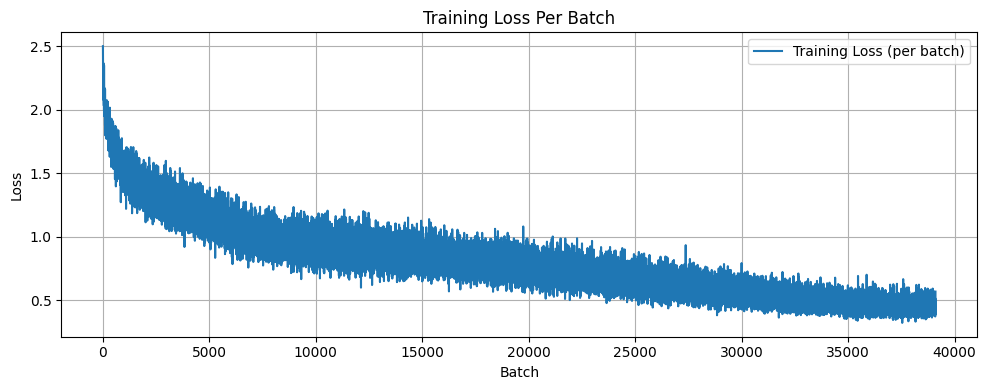

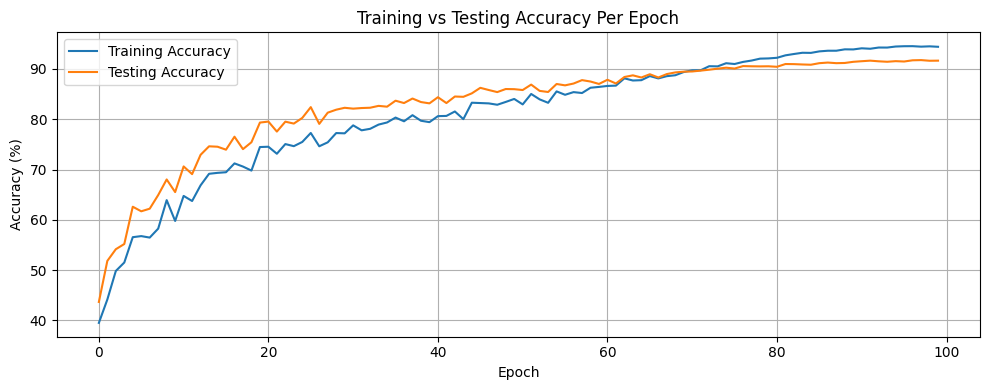

In [19]:
plot_metrics(metrics)